In [1]:
import datasets
import numpy

lithium_threshold = 80

geochemical_analysis = datasets.geochemical_analysis()

In [2]:
import reproducibility

# Best seed: 655
seed = 655

reproducibility.seed_random(seed)

C:\Users\ongan\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
lithium_column = "LI"

x_labels = ["RB", "K2O", "YB", "LA", "MGO", "U", "BA", "TH", "SN", "Rb_K2O", "Rb_Yb", "Rb_La", "K2O_MgO", "Rb_MgO", "U_Ba", "Ba_La", "U_Th", "Rb_Sn", "K2O_Sn"]
y_labels = [lithium_column]

geochemical_analysis_lithium_measured = geochemical_analysis[x_labels + y_labels].dropna(subset=y_labels)
geochemical_analysis_complete = geochemical_analysis[x_labels + y_labels].dropna()
geochemical_analysis_incomplete = geochemical_analysis_lithium_measured.drop(geochemical_analysis_complete.index)
geochemical_analysis_train = geochemical_analysis_complete.sample(frac=0.8, random_state=seed)
geochemical_analysis_test = geochemical_analysis_complete.drop(geochemical_analysis_train.index)
geochemical_analysis_peru = geochemical_analysis[geochemical_analysis["COUNTRY"] == "PERU"][x_labels + y_labels].dropna(subset=y_labels)

x_train = geochemical_analysis_train[x_labels].to_numpy(numpy.float32)
y_train = geochemical_analysis_train[y_labels].to_numpy(numpy.float32)
x_test = geochemical_analysis_test[x_labels].to_numpy(numpy.float32)
y_test = geochemical_analysis_test[y_labels].to_numpy(numpy.float32)

In [4]:
import models

model = models.neural_network(x_train.shape[1], 3)
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=0)
test_scores = model.evaluate(x_test, y_test, verbose=2)

model.save("Models/lithium_model")

26/26 - 0s - loss: 27926.2305 - mean_absolute_error: 30.9253 - mean_squared_error: 27926.2305 - root_mean_squared_error: 167.1114 - 24ms/epoch - 941us/step
INFO:tensorflow:Assets written to: Models/lithium_model\assets


In [5]:
from analysis import *

Number of Training Samples: 3306
Number of Test Samples: 827
True Positives = 76
False Positives = 12
True Negatives = 712
False Negatives = 27
accuracy = 0.9528415961305925
precision = 0.8636363636363636
recall = 0.7378640776699029
f1 = 0.7958115183246073


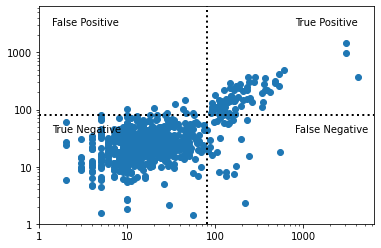

In [6]:
y_predicted = model.predict(x_test, verbose=0)

print(f"Number of Training Samples: {x_train.shape[0]}")
print(f"Number of Test Samples: {x_test.shape[0]}")

comparison, confusion_matrix = evaluate_performance(y_test[:,0], y_predicted[:,0], lithium_threshold)

import matplotlib.pyplot
import matplotlib.ticker

xmin = 1
xmax = 6400
ymin = 1
ymax = 6400

matplotlib.pyplot.scatter(comparison["Actual"].to_list(), comparison["Predicted"].to_list())
matplotlib.pyplot.xscale("log")
matplotlib.pyplot.yscale("log")
matplotlib.pyplot.xlim([xmin, xmax])
matplotlib.pyplot.ylim([ymin, ymax])
axes = matplotlib.pyplot.gca()
axes.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axes.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
matplotlib.pyplot.hlines(y=lithium_threshold, xmin=xmin, xmax=xmax, colors="black", ls=":", lw=2)
matplotlib.pyplot.vlines(x=lithium_threshold, ymin=ymin, ymax=ymax, colors="black", ls=":", lw=2)
matplotlib.pyplot.text(1.4, 3000, "False Positive")
matplotlib.pyplot.text(800, 3000, "True Positive")
matplotlib.pyplot.text(1.4, 40, "True Negative")
matplotlib.pyplot.text(800, 40, "False Negative")

import pathlib
pathlib.Path("Output").mkdir(parents=True, exist_ok=True)

matplotlib.pyplot.savefig("Output/Predicted vs Actual Lithium Concentrations.png")

In [7]:
geochemical_analysis_unknown = geochemical_analysis[x_labels].drop(geochemical_analysis_complete.index).dropna()
x_unknown = geochemical_analysis_unknown[x_labels].to_numpy(numpy.float32)
y_unknown = model.predict(x_unknown, verbose=0)
geochemical_analysis_unknown[lithium_column] = y_unknown[:,0]
geochemical_analysis_unknown.to_csv("Output/Lithium Predictions for Unanalyzed Samples.csv", sep=",")

True Positives = 325
False Positives = 103
True Negatives = 3527
False Negatives = 178
accuracy = 0.9320106460198403
precision = 0.7593457943925234
recall = 0.6461232604373758
f1 = 0.6981740064446831


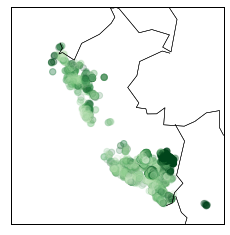

In [8]:
x_all = geochemical_analysis_complete[x_labels].to_numpy(numpy.float32)
y_all = geochemical_analysis_complete[y_labels].to_numpy(numpy.float32)

y_all_predicted = model.predict(x_all, verbose=0)

(comparison, confusion_matrix) = evaluate_performance(y_all[:,0], y_all_predicted[:,0], lithium_threshold)

from mpl_toolkits.basemap import Basemap

original_rows = geochemical_analysis.drop(geochemical_analysis.drop(geochemical_analysis_complete.index).index)

greens = matplotlib.cm.Greens
greens_with_transparency = greens(numpy.arange(greens.N))
greens_with_transparency[:,-1] = numpy.linspace(0, 1, greens.N)
greens_with_transparency = matplotlib.colors.ListedColormap(greens_with_transparency)

map = Basemap(projection="merc", resolution="c", lat_0=-9.19, lon_0=-75.0, llcrnrlat=-20, llcrnrlon=-85, urcrnrlat=0, urcrnrlon=-65)
map.drawcountries()
map.drawmapboundary()
x, y = map(original_rows["LONGITUDE"], original_rows["LATITUDE"])
matplotlib.pyplot.scatter(x, y, s=40, c=comparison["Predicted"] / 40, cmap=greens_with_transparency, alpha=0.1, norm=matplotlib.colors.NoNorm())
matplotlib.pyplot.savefig("Output/Peru Predicted Lithium Concentration.png")

map = Basemap(projection="merc", resolution="c", lat_0=-9.19, lon_0=-75.0, llcrnrlat=-20, llcrnrlon=-85, urcrnrlat=0, urcrnrlon=-65)
map.drawcountries()
map.drawmapboundary()
x, y = map(original_rows["LONGITUDE"], original_rows["LATITUDE"])
matplotlib.pyplot.scatter(x, y, s=40, c=comparison["Actual"] / 40, cmap=greens_with_transparency, alpha=0.1, norm=matplotlib.colors.NoNorm())

matplotlib.pyplot.savefig("Output/Peru Actual Lithium Concentration.png")

In [9]:
def print_lithium_statistics(data_frame, label):
    data_frame = data_frame.copy()
    lithium_threshold_column = "LI_Threshold"

    create_threshold_column(data_frame, lithium_column, lithium_threshold_column, lithium_threshold)

    print(f"{label}: Mean = {data_frame[lithium_column].mean()} | Standard Deviation = {data_frame[lithium_column].std()} | Median = {data_frame[lithium_column].median()} | Lithium Bearing = {data_frame[data_frame[lithium_threshold_column] == True].shape[0]} | Non-Lithium Bearing = {data_frame[data_frame[lithium_threshold_column] == False].shape[0]}")
    
print_lithium_statistics(geochemical_analysis_lithium_measured, "All")
print_lithium_statistics(geochemical_analysis_complete, "Complete")
print_lithium_statistics(geochemical_analysis_incomplete, "Incomplete")

incomplete_measurement_correction_factor = geochemical_analysis_incomplete["LI"].mean() / geochemical_analysis_complete["LI"].mean()

All: Mean = 39.41781013721646 | Standard Deviation = 132.71407009801783 | Median = 16.0 | Lithium Bearing = 618 | Non-Lithium Bearing = 6524
Complete: Mean = 47.821679167674816 | Standard Deviation = 155.2052271377095 | Median = 18.0 | Lithium Bearing = 503 | Non-Lithium Bearing = 3630
Incomplete: Mean = 27.874709205716186 | Standard Deviation = 92.15835369645414 | Median = 14.0 | Lithium Bearing = 115 | Non-Lithium Bearing = 2894


In [10]:
def impute_incomplete_data(data_frame, columns):
    import imputation
    return imputation.to_mean(data_frame, columns)
    
geochemical_analysis_incomplete_imputed = impute_incomplete_data(geochemical_analysis_incomplete, x_labels)

In [11]:
x_incomplete = geochemical_analysis_incomplete_imputed[x_labels].to_numpy(numpy.float32)
y_incomplete = geochemical_analysis_incomplete_imputed[y_labels].to_numpy(numpy.float32)

reproducibility.seed_random(49)
model_incomplete = models.neural_network(x_train.shape[1], 3)
history = model_incomplete.fit(x_incomplete, y_incomplete, batch_size=64, epochs=10, validation_split=0.2, verbose=0)

comparison, confusion_matrix = evaluate_performance(y_incomplete[:,0], model_incomplete.predict(x_incomplete, verbose=0)[:,0], lithium_threshold)

model.save("Models/lithium_model_incomplete")

True Positives = 45
False Positives = 3
True Negatives = 2891
False Negatives = 70
accuracy = 0.9757394483217016
precision = 0.9375
recall = 0.391304347826087
f1 = 0.5521472392638037
INFO:tensorflow:Assets written to: Models/lithium_model_incomplete\assets


To hunt for seeds:

```
for i in range(1, 1000):
    reproducibility.seed_random(i)
    model_incomplete = models.neural_network(x_train.shape[1], 3)
    history = model_incomplete.fit(x_incomplete, y_incomplete, batch_size=64, epochs=10, validation_split=0.2, verbose=0)

    comparison, confusion_matrix = evaluate_performance(y_incomplete[:,0], model_incomplete.predict(x_incomplete, verbose=0)[:,0], lithium_threshold, verbose=0)

    if confusion_matrix.f1_score > 0.5:
        print(f"Seed = {i} | Accuracy = {int(confusion_matrix.accuracy * 100)} | Precision = {int(confusion_matrix.precision * 100)} | Recall = {int(confusion_matrix.recall * 100)} | F1 = {int(confusion_matrix.f1_score * 100)}")
```

In [12]:
geochemical_analysis_peru_complete = geochemical_analysis_peru.dropna(subset=x_labels)
geochemical_analysis_peru_incomplete = geochemical_analysis_peru.drop(geochemical_analysis_peru_complete.index)
geochemical_analysis_peru_incomplete_imputed = impute_incomplete_data(geochemical_analysis_peru_incomplete, x_labels)

x_peru_complete = geochemical_analysis_peru_complete[x_labels].to_numpy(numpy.float32)
y_peru_complete = geochemical_analysis_peru_complete[y_labels].to_numpy(numpy.float32)

x_peru_incomplete = geochemical_analysis_peru_incomplete_imputed[x_labels].to_numpy(numpy.float32)
y_peru_incomplete = geochemical_analysis_peru_incomplete_imputed[y_labels].to_numpy(numpy.float32)

print()
_, confusion_matrix_complete = evaluate_performance(y_peru_complete[:,0], model.predict(x_peru_complete, verbose=0)[:,0], lithium_threshold)
print()
_, confusion_matrix_incomplete = evaluate_performance(y_peru_incomplete[:,0], model_incomplete.predict(x_peru_incomplete, verbose=0)[:,0], lithium_threshold)

confusion_matrix = confusion_matrix_complete + confusion_matrix_incomplete

print()
print(f"True Positives = {int(confusion_matrix.true_positives)}")
print(f"False Positives = {int(confusion_matrix.false_positives)}")
print(f"True Negatives = {int(confusion_matrix.true_negatives)}")
print(f"False Negatives = {int(confusion_matrix.false_negatives)}")
print(f"accuracy = {confusion_matrix.accuracy}")
print(f"precision = {confusion_matrix.precision}")
print(f"recall = {confusion_matrix.recall}")
print(f"f1 = {confusion_matrix.f1_score}")



True Positives = 314
False Positives = 102
True Negatives = 3524
False Negatives = 177
accuracy = 0.9322322079183871
precision = 0.7548076923076923
recall = 0.639511201629328
f1 = 0.6923925027563397

True Positives = 38
False Positives = 3
True Negatives = 2703
False Negatives = 71
accuracy = 0.9737122557726465
precision = 0.926829268292683
recall = 0.3486238532110092
f1 = 0.5066666666666667

True Positives = 352
False Positives = 105
True Negatives = 6227
False Negatives = 248
accuracy = 0.9490767455279862
precision = 0.7702407002188184
recall = 0.5866666666666667
f1 = 0.6660359508041627
